In [1]:
import time
import gym
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
class non_linear_Model(object):
    def __init__(self,thetaacc_error = 0, env_params_variation = [0,0,0,0], initial_state_variation = [0,0,0,0]):
        self.lstm_sizes = [128,64]
        self.thetaacc_error = thetaacc_error
        self.global_epoch = 0
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=self.thetaacc_error, env_params_var=env_params_variation, initial_state_var=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                                  dtype=np.float64),0)
        self.prediction = tf.keras.Sequential([layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01), name = 'prediction1'),
                                               layers.Dense(16, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01), name = 'prediction2'),
                                               layers.Dense(4, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01), name = 'prediction3')])
        self.u = tf.zeros(shape=[1,1], dtype = tf.float64)
        
#     def prediction(self,input):
        
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]
        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
        return self

    def look_ahead_prediction(self, prediction_horizon, observation, output_single, state_single):
        LA_preds = [tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)]
        LA_output_single = output_single
        LA_state_single = state_single
        LA_pred = tf.convert_to_tensor(observation,dtype=tf.float64)
        for i in range(prediction_horizon-1):
            LA_pred = self.prediction(output_single)
            LA_next_input = tf.concat((self.env_params,LA_pred),axis=1)
            LA_preds.append(LA_pred)
            LA_output_single,LA_state_single=self.cell(inputs=LA_next_input,state=LA_state_single)
        return LA_preds
    
    def __call__(self,prediction_horizon):
        rewards = 0
        predictions = []
        LA_predictions = []
        trajectory = []
        self.build_LSTM()
        observation = self.env.reset()
        trajectory.append(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0))
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)),
                                  axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
        predictions.append(self.prediction(output_single))
        done = False
        while not done:
            if rewards%prediction_horizon==0:
                LA_predictions.extend(self.look_ahead_prediction(prediction_horizon,observation,output_single,state_single))
            observation, reward, done, info = self.env.step(tf.squeeze(self.u))
            predictions.append(self.prediction(output_single))
            trajectory.append(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0))
            next_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation, dtype=tf.float64),0)),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)

            rewards += 1
        self.global_epoch += 1
        return predictions, LA_predictions, trajectory, rewards
    
def compute_loss(model, prediction_horizon):
    preds, LA_predictions, trajectory, rewards = model(prediction_horizon)
    loss = tf.Variable([0.0],dtype = tf.float64)
    for pred,z in zip(LA_predictions,trajectory):
        loss = tf.add(loss, tf.nn.l2_loss(pred-z))
    return loss, LA_predictions, preds, trajectory, rewards

def compute_gradient(model,prediction_horizon):
    with tf.GradientTape() as tape:
        loss, LA_predictions, preds, trajectory, rewards = compute_loss(model,prediction_horizon)
    return tape.watched_variables(), tape.gradient(loss,tape.watched_variables()), loss, preds, LA_predictions, trajectory, rewards

In [9]:
def train(model, num_epochs, optimizer, view_rate, prediction_horizon = 5):
    start = time.time()
    for i in range(num_epochs):
        watched_vars, grads, loss_, pred_, LA_pred_, z_, reward_ = compute_gradient(model, prediction_horizon)
        losses.extend(loss_)
        preds.append(pred_)
        look_ahead_preds.append(LA_pred_)
        trajectories.append(z_)
        rewards.append(reward_)
        optimizer.apply_gradients(zip(grads,watched_vars))
        if (model.global_epoch+1)%view_rate == 0:
            print('Epoch {}'.format(model.global_epoch+1))
            print('Minutes elapsed: {}'.format((time.time()-start)/60))
            print('Last {} averages: Loss: {}, reward: {}, loss/reward: {}'.format(view_rate,np.mean(losses[-view_rate:]), np.mean(rewards[-view_rate:]),
                                                                                   (np.mean(losses[-view_rate:])/np.mean(rewards[-view_rate:]))))
#             print('Model variables:')
#             for var in watched_vars:
#                 print(var.name)
            print()

In [10]:
test_model = non_linear_Model(env_params_variation=[0,0,0,0],initial_state_variation=[1,0.1,0.1,0.1])
optimizer = tf.train.AdamOptimizer()
losses = []
preds = []
look_ahead_preds = []
trajectories = []
rewards = []

In [11]:
train(test_model, 100, optimizer,50)

Epoch 50
Minutes elapsed: 0.44134195645650226
Last 50 averages: Loss: 45.38791643453096, reward: 52.42857142857143, loss/reward: 0.8657095777703452

Epoch 100
Minutes elapsed: 0.9348068912823995
Last 50 averages: Loss: 45.2927135042699, reward: 54.7, loss/reward: 0.8280203565680054



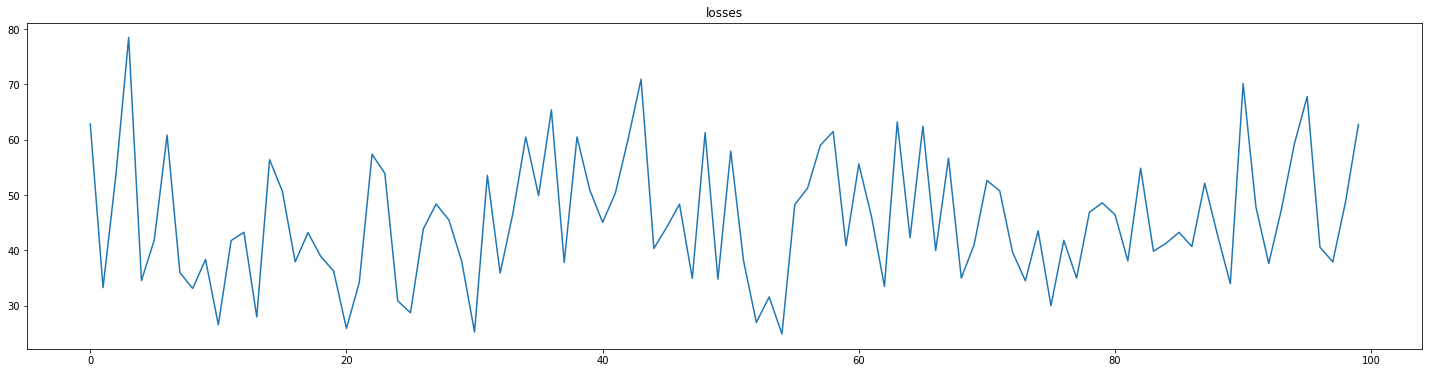

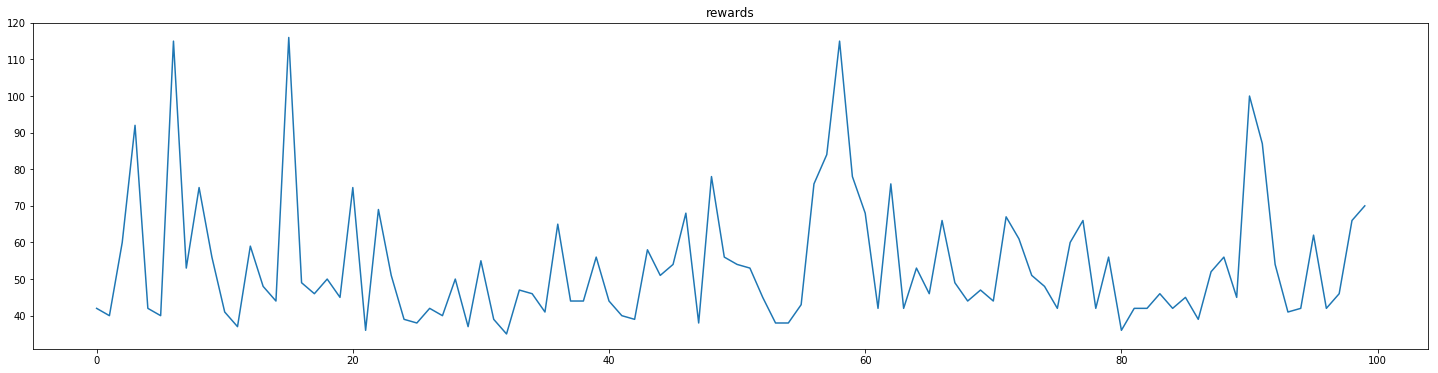

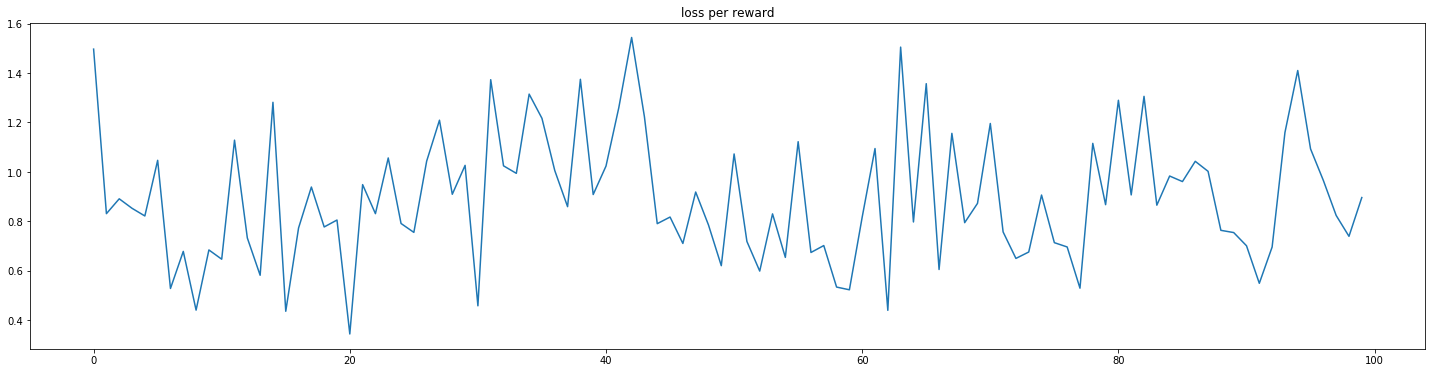

In [12]:
plt.figure(figsize=(25,6))
plt.plot(losses)
plt.title('losses')
plt.show()
plt.figure(figsize=(25,6))
plt.plot(rewards)
plt.title('rewards')
plt.show()
plt.figure(figsize=(25,6))
plt.plot([loss/reward for loss,reward in zip(losses,rewards)])
plt.title('loss per reward')
# plt.ylim(0,500)
plt.show()

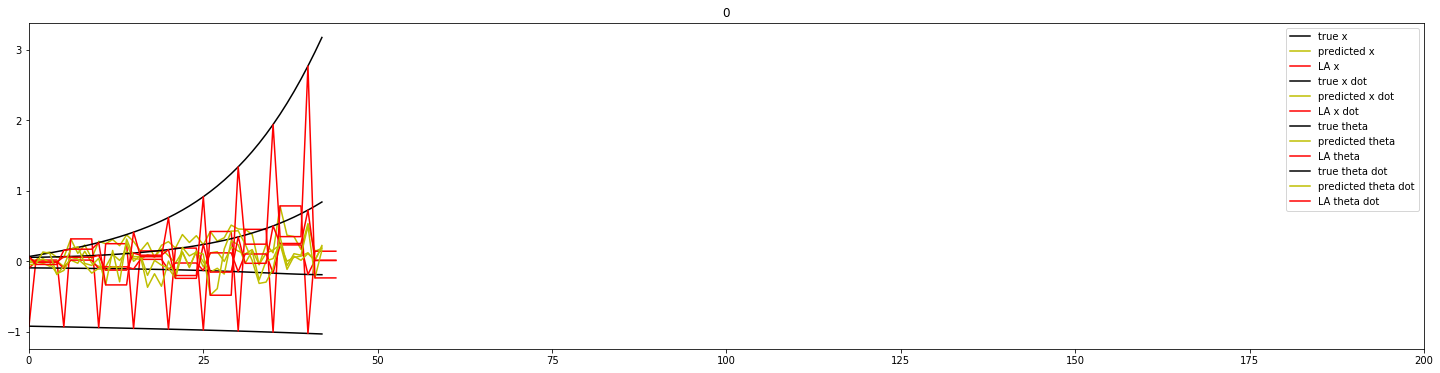

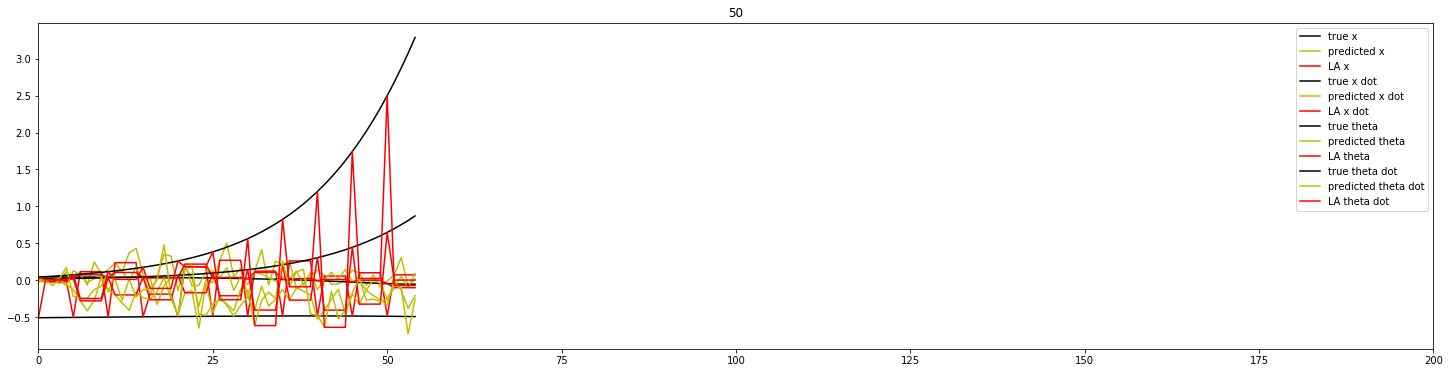

IndexError: list index out of range

<Figure size 1800x432 with 0 Axes>

In [13]:
truelabels = ['true x','true x dot', 'true theta','true theta dot']
predictedlabels = ['predicted x', 'predicted x dot', 'predicted theta', 'predicted theta dot']
lookaheadlabels = ['LA x', 'LA x dot', 'LA theta', 'LA theta dot']
for i in range(0,1000,50):
    plt.figure(figsize=(25,6))
    for j in range(4):
        plt.plot(np.squeeze(np.array(trajectories[i])).T[j], label = truelabels[j], color = 'k')
        plt.plot(np.squeeze(np.array(preds[i])).T[j], label = predictedlabels[j], color = 'y')
        plt.plot(np.squeeze(np.array(look_ahead_preds[i])).T[j],label=lookaheadlabels[j],color='r')
    plt.legend()
    plt.title(i)
    plt.xlim(0,200)
    plt.show()